Implement some different neuron models and show their membrane voltage / spikes in response to a stimulus current

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from scipy.signal import find_peaks

def plot_cur_mem_spk(cur, mem, spk, thr_line=False, title=False):
  '''Plot input current, membrane potential, and spike events'''
  fig, ax = plt.subplots(3, figsize=(8,6), sharex=True, 
                        gridspec_kw = {'height_ratios': [1, 1, 0.4]})

  # Plot input current
  ax[0].plot(cur, c="orange")
  ax[0].set_ylabel("Input Current ")
  if title:
    ax[0].set_title(title)

  # Plot membrane potential
  ax[1].plot(mem)
  ax[1].set_ylabel("Membrane Potential")
  if thr_line:
    ax[1].axhline(y=thr_line, alpha=0.25, linestyle="dashed", c="black", linewidth=2)
  plt.xlabel("Time step")

  # Plot spike events using eventplot
  spike_times = [i for i, spike in enumerate(spk) if spike == 1]
  ax[2].eventplot(spike_times, orientation='horizontal', lineoffsets=0, linelengths=1, colors='black')
  ax[2].set_ylabel("Spikes")

  plt.show()


Simulate a simple leaky integrate and fire neuron

In [2]:
R_m = 0.05    # Membrane resistance (MΩ/cm^2)
C_m = 1.0     # Membrane capacitance (uF/cm^2)
# tau_m = 10.0 ms for the above R_m and C_m, which is a reasonable value for a neuron
V_rest = -65  # Resting potential (mV)
V_thresh= -50 # Firing threshold (mV)

def leaky_integrate_and_fire(V_mem, current, 
                             V_thresh=V_thresh, V_rest=V_rest, dt=1e-3, R=R_m, C=C_m):
  '''Simulate a single step of LIF dynamics'''
  tau_mem = R*C
  V_mem = V_mem + (dt/tau_mem) * (-V_mem + current * R)
  spike = int(V_mem > V_thresh)
  # Every time we fire a spike, return to threshold
  if spike:
    V_mem = V_rest
  return V_mem, spike


Simulate a neuron using the Hodgkin-Huxley equations

In [29]:
C_m = 1.0           # Membrane capacitance (uF/cm^2)
g_Na_max = 120.0    # Maximum sodium conductance (mS/cm^2)
g_K_max = 36.0      # Maximum potassium conductance (mS/cm^2)
g_l = 0.3           # Leak conductance (mS/cm^2)
E_Na = 55.17        # Sodium equilibrium potential (mV)
E_K = -72.14        # Potassium equilibrium potential (mV)
E_l = -49.24        # Leak equilibrium potential (mV)

# Define rate constant functions for ion gating variables
an = lambda v: 0.01 * (-50 - v) / (np.exp((-50 - v) / 10) - 1)
Bn = lambda v: 0.125 * np.exp((-60 - v) / 80)
am = lambda v: 0.1 * (-35 - v) / (np.exp((-35 - v) / 10) - 1)
Bm = lambda v: 4 * np.exp((-60 - v) / 18)
ah = lambda v: 0.07 * np.exp((-60 - v) / 20)
Bh = lambda v: 1 / (np.exp((-30 - v) / 10) + 1)

def hodgkin_huxley(V_mem, current, m, h, n,
                   V_thresh=-50, dt=1e-2, C=C_m):
    '''Simulate a single step of Hodgkin-Huxley dynamics'''
    
    # Compute conductances
    g_Na = g_Na_max * (m ** 3) * h
    g_K = g_K_max * (n ** 4)
    
    # Compute ionic currents
    I_Na = g_Na * (V_mem - E_Na)
    I_K = g_K * (V_mem - E_K)
    I_l = g_l * (V_mem - E_l)
    
    # Update state variables
    m = m + dt * (am(V_mem) * (1 - m) - Bm(V_mem) * m)
    h = h + dt * (ah(V_mem) * (1 - h) - Bh(V_mem) * h)
    n = n + dt * (an(V_mem) * (1 - n) - Bn(V_mem) * n)
    V_mem = V_mem - dt / C * (I_Na + I_K + I_l - current)

    # We'll define the spike time as when we hit action potential firing threshold (instead of peak)
    # (& make sure potassium conductance is low so we catch the rising edge not the falling edge)
    spike = int((abs(V_mem - V_thresh) <= 0.03) and g_K < 1)
    return V_mem, spike, m, h, n


Now simulate those neurons response to an stimulus current!

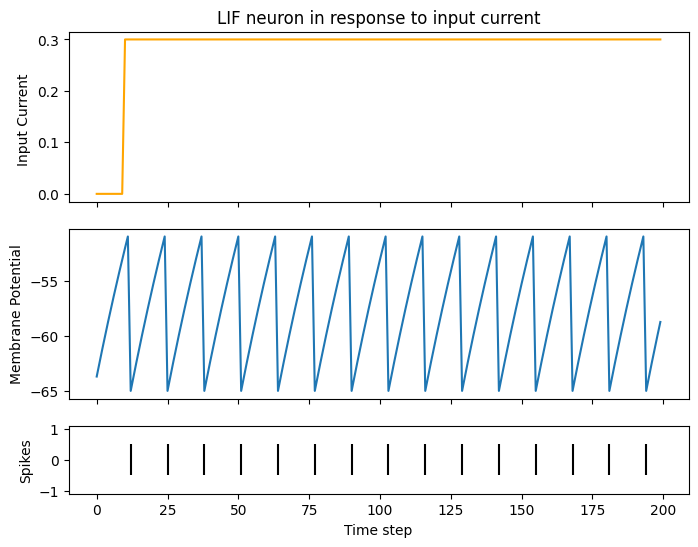

In [19]:
num_steps = 200

# Stimulus current
current_amt = 0.3
input_current = torch.cat((torch.zeros(10), torch.ones(num_steps-10)*current_amt), 0)

# Start the membrane at rest
LIF_mem = V_rest

# Set up lists to store membrane voltage and spikes
LIF_mem_list = []
LIF_spk_list = []

# Neuron simulation
for step in range(num_steps):
  LIF_mem, spk = leaky_integrate_and_fire(LIF_mem, input_current[step])
  LIF_mem_list.append(LIF_mem)
  LIF_spk_list.append(spk)

# Plot
plot_cur_mem_spk(input_current, LIF_mem_list, LIF_spk_list, title="LIF neuron in response to input current")

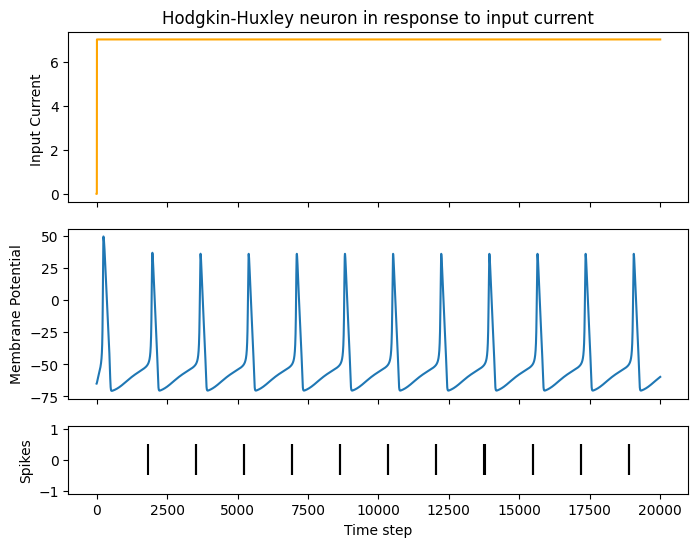

In [30]:
num_steps = 20000

# Stimulus current
current_amt = 7
input_current = torch.cat((torch.zeros(10), torch.ones(num_steps-10)*current_amt), 0)

# Start the membrane at rest
HH_mem = V_rest

# Initialize gating variables for HH neuron
m = am(V_rest) / (am(V_rest) + Bm(V_rest))
h = ah(V_rest) / (ah(V_rest) + Bh(V_rest))
n = an(V_rest) / (an(V_rest) + Bn(V_rest))

# Set up lists to store membrane voltage and spikes
HH_mem_list = []
HH_spk_list = []

# Neuron simulation
for step in range(num_steps):
    HH_mem, spk, m, h, n = hodgkin_huxley(HH_mem, input_current[step], m, h, n)
    HH_mem_list.append(HH_mem)
    HH_spk_list.append(spk)

# Plot
plot_cur_mem_spk(input_current, HH_mem_list, HH_spk_list, title="Hodgkin-Huxley neuron in response to input current")